In [3]:
'''
File name: Project.ipynb
Date created: 01/11/2022
Date last modified: 18/11/2022
Python Version: 3.9.13
'''

'\nFile name: Project.ipynb\nDate created: 01/11/2022\nDate last modified: 17/11/2022\nPython Version: 3.9.13\n'

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations  #used to create unique pairs from a list
import numpy as np
import plotly.express as px  #for plots with integrated cursor for better visualization
#from pandas_profiling import ProfileReport

DATA_FOLDER = 'MovieSummaries/'

In [5]:
#Create dataframes from the orignal dataset 
moviedata = pd.read_csv(DATA_FOLDER + 'movie.metadata.tsv', sep = '\t', index_col='wiki_id' , header=None, names=('wiki_id','freebase_id','movie_name','release','revenue','runtime','languages','countries','genres'))
charadata = pd.read_csv(DATA_FOLDER + 'character.metadata.tsv', sep = '\t', header=None, names=('wiki_id','freebase_id','release','character_name','actor_dob','actor_gender','actor_height','actor_ethnicity','actor_name','actor_age','freebase_chara_map1','freebase_chara_map2','freebase_chara_map3'))
plots =  pd.read_csv(DATA_FOLDER + 'plot_summaries.txt', sep = '\t', header=None, names=('wiki_id','plot'))

In [6]:
#Set the commom index present in all datasets as wiki_id
charadata.set_index('wiki_id',inplace=True)
plots.set_index('wiki_id',inplace=True)

### Data Exploration

In [7]:
#Filter the three datasets to obtain only movies which have a list of characters and a plot summary
indexes = moviedata.index.intersection(charadata.index)
indexes = plots.index.intersection(indexes)

#Create new filtered dataset using indexes of movies common to the three datasets
moviedata_intersect = moviedata.loc[indexes]
charadata_intersect = charadata.loc[indexes]
plots_intersect = plots.loc[indexes]

In [8]:
print('We had originally the plot summaries of {} movies. After the intersect, we get a total of {} movies from which we have the characters and the plot summaries. Proportion filtered out: {:.2%}.\n'.format(len(plots),len(plots_intersect),1-(len(plots_intersect)/len(plots))))
print('The movie metadata contained originally {} movies. After filtering the dataset, we get {} movies. Proportion filtered out: {:.2%}.\n'.format(len(moviedata),len(moviedata_intersect),1-(len(moviedata_intersect)/len(moviedata))))
print('The character metadata contained originally {} characters. After filtering the dataset, we get {} characters. Proportion filtered out: {:.2%}.'.format(len(charadata),len(charadata_intersect),1-(len(charadata_intersect)/len(charadata))))
print('There are in average {:.2f} characters per movie.'.format(len(charadata_intersect)/len(moviedata_intersect)))

We had originally the plot summaries of 42303 movies. After the intersect, we get a total of 37779 movies from which we have the characters and the plot summaries. Proportion filtered out : 10.69%.

The movie metadata contained originally 81741 movies. After filtering the dataset, we get 37779 movies. Proportion filtered out : 53.78%.

The character metadata contained originally 450669 characters. After filtering the dataset, we get 308485 characters. Proportion filtered out : 31.55%.
There are in average 8.17 characters per movie.


#### Analysis resultig from profiling : 

Movies dataset :

- 80% of missing values in revenue : we cannot use this feature.

- Outliers within runtime :  *We are not going to use this feature*

 Character dataset :  
 
- Unknowed gender : *These actors play unnamed character in 80% of the cases, we could avoid using them when running some analysis*

- Outlier in actor age : *225 values <0 probably due to mistakes, we take these values out to observe distribution*

- Ethnicity : Hard to use, 75% of missing values

- Height : 60% of missing values and outliers, anyway not relevant feature in our case

Code to observe these statements : 

In [9]:
#Look at outliers in movies runtime
print("Number of movies with excessive (>400 min) runtime:", moviedata_intersect['runtime'][moviedata_intersect['runtime']>400].shape[0])
moviedata_intersect[moviedata_intersect['runtime']>400].head(5)


Number of movies with excessive (>400min) runtime : 20


,freebase_id,movie_name,release,revenue,runtime,languages,countries,genres
wiki_id,,,,,,,,
25930191,/m/0gxf936,Swallow the Sun,2009,NaN,1560.0,{},{},{}
147213,/m/012tj4,Shoah,1985,NaN,544.0,"{""/m/064_8sq"": ""French Language"", ""/m/03hkp"": ...","{""/m/0f8l9c"": ""France""}","{""/m/03g3w"": ""History"", ""/m/082gq"": ""War film""..."
2792417,/m/082yvg,War and Peace,1968-04-28,NaN,401.0,"{""/m/064_8sq"": ""French Language"", ""/m/06b_j"": ...","{""/m/05vz3zq"": ""Soviet Union"", ""/m/06bnz"": ""Ru...","{""/m/03g3w"": ""History"", ""/m/02l7c8"": ""Romance ..."
1060418,/m/042j6p,The 10th Kingdom,2000-02-27,NaN,417.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3n2k"": ""Fantasy Adventure"", ""/m/015w9s..."
19653659,/m/04myhqx,TASS Is Authorized to Declare,1984,NaN,700.0,"{""/m/06b_j"": ""Russian Language""}","{""/m/05vz3zq"": ""Soviet Union""}","{""/m/03k9fj"": ""Adventure""}"


As one can see, most of the other informations for runtime outliers (expect missing values that will be handled during data filtering) seem to be coherent. As the runtime is not considered for our analysis, we do not need to discard all movies associated to runtime outliers. 

In [10]:
#Look at missing values in actor_gender
print ("Proportion of character without name among actors whose gender is unknown : {0:.2%}".format(charadata_intersect['character_name'][charadata_intersect['actor_gender'].isna()].isna().sum()/len(charadata_intersect['character_name'][charadata_intersect['actor_gender'].isna()])))

Proportion of character without name among actors whose gender is unknown : 81.81%


As we can see, most of non specificied genders arise from unnamed characters, which probably means that these characters are negligable. Thus, we won't take these characters into acount when running analysis on genders.

In [11]:
#Look at outliers in actor age
print("Number of errors in actors age :",len(charadata_intersect[charadata_intersect['actor_age']<0]))
charadata_intersect[charadata_intersect['actor_age']<0].head()

Number of errors in actors age : 225


,freebase_id,release,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,freebase_chara_map1,freebase_chara_map2,freebase_chara_map3
wiki_id,,,,,,,,,,,,
22829,/m/05q8n,1965-06-01,The Black Ghoul,1978-07-18,F,NaN,/m/03ts0c,Cheyenne Silver,-13.0,/m/0cbwtz8,/m/0cbwtzc,/m/06616j
4210812,/m/0bq4vz,1910-03-24,Glinda,1992-02-17,M,NaN,NaN,Olive Cox,-81.0,/m/09z696c,/m/022qn6,/m/09z696h
5626726,/m/0dx12p,1936-02-14,NaN,1944-12-09,M,NaN,NaN,Bob O'Connor,-8.0,/m/0k4k1m,NaN,/m/064_gh
7735007,/m/0kvg60,1966,NaN,1996-08-14,M,NaN,NaN,Jack Fletcher,-30.0,/m/0gcmsrc,NaN,/m/07p1ck
6667989,/m/0ggp41,1960-09-22,Khalillah,1989-05-05,F,1.6,NaN,Larissa Wilson,-28.0,/m/063lmhz,/m/063lmj0,/m/02pv8ss


There are 225 outliers with incoherent values for an age, most likely due to errors. As these outliers are only 225 and represent a very small part of all characters, the outliers will then be further discarded during data filtering.

#### Filtering data

Here we remove all columns that will not be useful for the further analysis. In addition, we remove all characters with missing values in release date and/or gender as we want to study women's representation over time. We can see that the release date is not constant and thus we need to homogenize it into only the year of the release.

In [12]:
#For each character, drop columns which have no use for our analysis and homogenize the release date 
charadata_filtered = charadata_intersect.drop(['freebase_id','actor_dob', 'actor_height', 'actor_ethnicity', 'freebase_chara_map1','freebase_chara_map2','freebase_chara_map3'], axis = 1)
charadata_filtered['release'] = pd.to_datetime(charadata_filtered['release'], errors = 'coerce')
charadata_filtered['release'] = pd.DatetimeIndex(charadata_filtered['release']).year
charadata_filtered = charadata_filtered[charadata_filtered['release'].notna()]
charadata_filtered['release'] = charadata_filtered['release'].astype(int)

charadata_filtered = charadata_filtered[charadata_filtered['actor_gender'].notna()] #drop characters who do not have a gender
charadata_filtered = charadata_filtered[charadata_filtered['actor_age']>=0] #remove characters with negative ages values

#For each movie, drop columns which have no use for our analysis and homogenize the release date
moviedata_filtered = moviedata_intersect.drop(['freebase_id','revenue','runtime','languages'], axis = 1)
moviedata_filtered['release'] = pd.to_datetime(moviedata_filtered['release'], errors = 'coerce')
moviedata_filtered['release'] = pd.DatetimeIndex(moviedata_filtered['release']).year
moviedata_filtered = moviedata_filtered[moviedata_filtered['release'].notna()]
moviedata_filtered['release'] = moviedata_filtered['release'].astype(int)


#Remove the genre ID (e.g. /m/07s9rl0)to get only the string of the genres to allow analysis
moviedata_filtered['genres'] = moviedata_filtered['genres'].apply(lambda x : x.replace(':', ','))
moviedata_filtered['genres'] = moviedata_filtered['genres'].apply(eval)
moviedata_filtered['genres'] = moviedata_filtered['genres'].apply(lambda x: list(x))
moviedata_filtered['genres'] = moviedata_filtered['genres'].apply(lambda y: list(filter(lambda x: not x.startswith('/m'), y)))
#do the same for the countries names
moviedata_filtered['countries'] = moviedata_filtered['countries'].apply(lambda x : x.replace(':', ','))
moviedata_filtered['countries'] = moviedata_filtered['countries'].apply(eval)
moviedata_filtered['countries'] = moviedata_filtered['countries'].apply(lambda x: list(x))
moviedata_filtered['countries'] = moviedata_filtered['countries'].apply(lambda y: list(filter(lambda x: not x.startswith('/m'), y)))

#Keep only the overlap of the three datasets to obtain only movies which have a list of characters and a plot summary after the filter
indexes_filtered = moviedata_filtered.index.intersection(charadata_filtered.index)
indexes_filtered = plots.index.intersection(indexes_filtered)

moviedata_filtered = moviedata_filtered.loc[indexes_filtered]
charadata_filtered = charadata_filtered.loc[indexes_filtered]
plots_filtered = plots_intersect.loc[indexes_filtered]

In [13]:
moviedata_filtered.head()

,movie_name,release,countries,genres
wiki_id,,,,
23890098,Taxi Blues,1990,"[France, Russia, Soviet Union]","[Drama, World cinema]"
31186339,The Hunger Games,2012,[United States of America],"[Drama, Action/Adventure, Action, Science Fict..."
20663735,Narasimham,2000,[India],"[Drama, Musical, Action, Bollywood]"
2231378,The Lemon Drop Kid,1951,[United States of America],"[Screwball comedy, Comedy]"
595909,A Cry in the Dark,1988,"[New Zealand, Australia, United States of Amer...","[Courtroom Drama, Drama, Docudrama, World cine..."


In [14]:
#We look at the missing information for the remainings movies in the movie metadata
moviedata_filtered.isna().sum()

movie_name    0
release       0
countries     0
genres        0
dtype: int64

#### Visualization

First, we want to study the proportions of male and female characters across all movies from the dataset, to gain insight on the relative gender proportions in the whole dataset.

First we wish to have a look at the numbers and proportions of male and female characters across all movies :
There are 139691 male characters, corresponding to 66.14% of all characters
There are 71526 female characters, corresponding to 33.86% of all characters


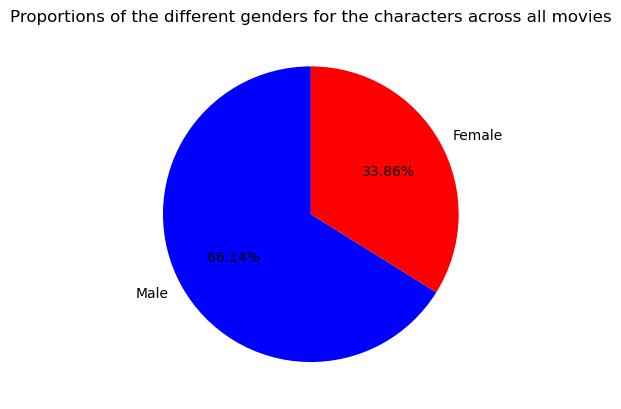

In [15]:
#Assess women's presence accross all charaters from every movies
M_count = charadata_filtered[charadata_filtered.actor_gender == 'M'].shape[0]
F_count = charadata_filtered[charadata_filtered.actor_gender == 'F'].shape[0]

M_proportion = M_count / (M_count + F_count)
F_proportion = F_count / (M_count + F_count)

print("First we wish to have a look at the numbers and proportions of male and female characters across all movies :")
print("There are {} male characters, corresponding to {:.2f}% of all characters".format(M_count, M_proportion*100))
print("There are {} female characters, corresponding to {:.2f}% of all characters".format(F_count, F_proportion*100))

plt.pie([M_proportion, F_proportion], labels = ["Male", "Female"], startangle = 90, autopct = "%0.2f%%",colors=['blue','red'])
plt.title("Proportions of the different genders for the characters across all movies")
plt.show()

Then, we want to further assess the relative gender representation by looking at the relative proportions of male and female characters in each movie.

In [16]:
#Assess average gender presence per movie 
gender_count_permovie = charadata_filtered.groupby('wiki_id').apply(lambda x : pd.Series({'nb_male' : x[x.actor_gender == 'M'].shape[0], 
                                                                                       'nb_female' : x[x.actor_gender == 'F'].shape[0]}))
                                                                                       
#Compute proportions of each gender per movie
gender_count_permovie['M_proportion'] = gender_count_permovie.nb_male / (gender_count_permovie.nb_male + gender_count_permovie.nb_female)
gender_count_permovie['F_proportion'] = gender_count_permovie.nb_female / (gender_count_permovie.nb_male + gender_count_permovie.nb_female)

gender_count_permovie.head()

,nb_male,nb_female,M_proportion,F_proportion
wiki_id,,,,
330,0,4,0.000000,1.000000
3217,9,3,0.750000,0.250000
3333,0,1,0.000000,1.000000
3746,10,3,0.769231,0.230769
3837,18,2,0.900000,0.100000


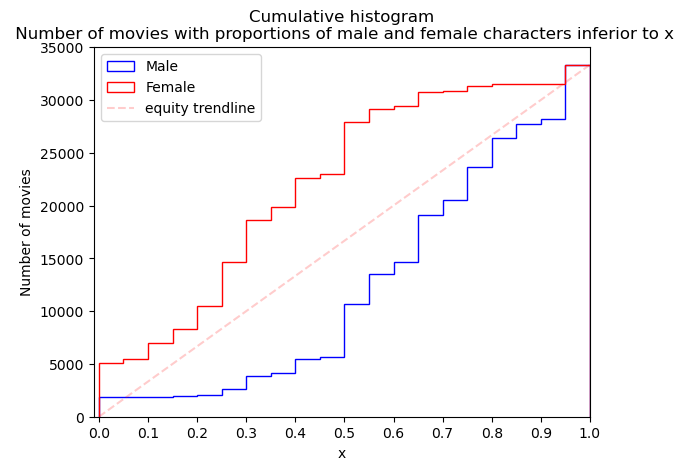

In [17]:
plt.hist(gender_count_permovie.M_proportion, bins = 20, cumulative = True, histtype = 'step',label='Male',color='blue')
plt.hist(gender_count_permovie.F_proportion, bins = 20, cumulative = True, histtype = 'step',label='Female',color='red')
plt.plot([0,1], [0, gender_count_permovie.shape[0]], color = 'red', ls = '--', alpha = 0.2, label = 'equity trendline')
plt.xlim(-0.01,1)
plt.xticks(np.arange(0,1.1,0.1))
plt.title("Cumulative histogram\n Number of movies with proportions of male and female characters inferior to x")
plt.xlabel('x')
plt.ylabel('Number of movies')
plt.legend(loc='upper left')
plt.show()

The graph above presents two cumulative histograms representing the number of movies in which the proportion of male or female characters is inferior to the corresponding proportion on the x-axis.

The dotted "equity trendline" represents the expected form of the cumulative histograms if the representations of each gender were equal, in the sens that the proportions of movies in which there is less than a certain proportion x of female (or male characters) should be equal to a proportion x of all movies. 

Therefore, any cumulative histogram above this trendline is biased towards the gender that it represents (i.e., this gender would be over-represented) and any cumulative hsitogram under the trendline represent a gender that would be under-represented. 

As one can see, male characters are significantly more represented than female characters as the numbers of movies in which they are certain proportion **x** of male characters is always higher than this proportion **x** of the total numbers of movies. In the same way, female characters are significantly under-represented.

Below, we look at the proportion of movies starring different number of male and female actors. 

In [18]:
max_M = 0
max_F = 0
equal_MF = 0
for i in range(gender_count_permovie.shape[0]) :
    if (gender_count_permovie.iloc[i]['nb_male'] > gender_count_permovie.iloc[i]['nb_female']) :
        max_M += 1
    elif (gender_count_permovie.iloc[i]['nb_male'] < gender_count_permovie.iloc[i]['nb_female']) : 
        max_F += 1
    elif (gender_count_permovie.iloc[i]['nb_male'] == gender_count_permovie.iloc[i]['nb_female']) :
        equal_MF += 1

print(f'The number of movies with more male actors than female actors is : {max_M}.')
print(f'The number of movies with more female actors than male actors is : {max_F}.')
print(f'The number of movies with equal number of male and female actors is : {equal_MF}.')

The number of movies with more male actors than female actors is : 23028.
The number of movies with more female actors than male actors is : 5692.
The number of movies with equal number of male and female actors is : 4632.


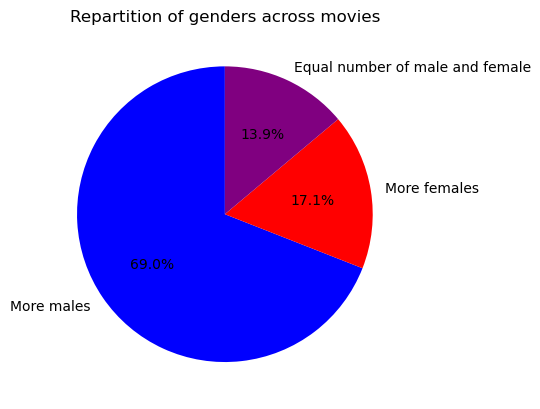

In [19]:
plt.pie([max_M,max_F,equal_MF], labels = ["More males", "More females", "Equal number of male and female"], startangle = 90, autopct = "%0.1f%%",colors=['blue','red','purple'])
plt.title("Repartition of genders across movies")
plt.show()

To further analyse men and women representation in movies, we computed the mean, median and std of the number of movies each gender stars in. This helps to show further differences, as men tend to play in more movies than women.

In [20]:
movies_count_peractor = charadata_filtered.groupby('actor_name').apply(lambda x : pd.Series({'actor_gender' : x['actor_gender'].unique()[0], 
                                                                                       'num_movies' : x.index.nunique()}))
movies_count_peractor.head()

,actor_gender,num_movies
actor_name,,
'King Kong' Kashey,M,1
2 Tuff Tony,M,1
40 Glocc,M,1
50 Cent,M,15
A Martinez,M,8


In [21]:
mean_M = (movies_count_peractor[movies_count_peractor['actor_gender']=='M']['num_movies']).mean()
mean_F = (movies_count_peractor[movies_count_peractor['actor_gender']=='F']['num_movies']).mean()
median_M = (movies_count_peractor[movies_count_peractor['actor_gender']=='M']['num_movies']).median()
median_F = (movies_count_peractor[movies_count_peractor['actor_gender']=='F']['num_movies']).median()
std_M = (movies_count_peractor[movies_count_peractor['actor_gender']=='M']['num_movies']).std()
std_F = (movies_count_peractor[movies_count_peractor['actor_gender']=='F']['num_movies']).std()
print('Median number of movies per male actor =',median_M,'mean number of movies per male actor =',mean_M, 'std =',std_M)
print('Median number of movies per female actor =',median_F,'mean number of movies per female actor =',mean_F, 'std =',std_F)

Median number of movies per male actor = 2.0 mean number of movies per male actor = 5.40801064954387 std = 9.64303182027481
Median number of movies per female actor = 2.0 mean number of movies per female actor = 4.512440343620744 std = 6.576056233462031


Finally, another crucial aspect looking at women representation is the difference in age between men and women in movies. Indeed, women tend to be represented younger than men, and we wanted to assess this statement by looking at the distribution of ages of actors between genders.

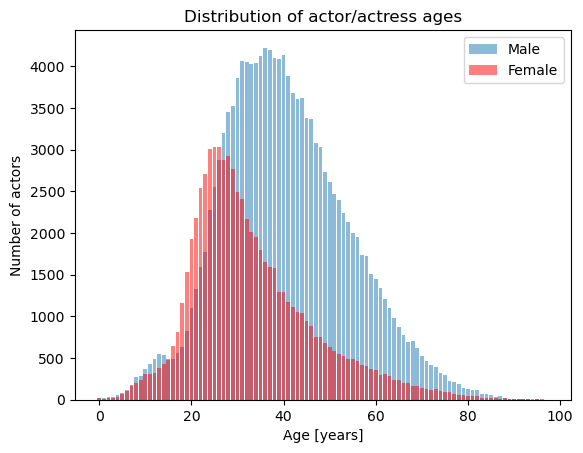

In [22]:
#Plot age distribution across gender

df_wo_ol = charadata_filtered[charadata_filtered['actor_age']>=0]
M = df_wo_ol[df_wo_ol['actor_gender']=='M']
F = df_wo_ol[df_wo_ol['actor_gender']=='F']
Mc = M['actor_age'].value_counts()
Fc = F['actor_age'].value_counts()

plt.bar(np.sort(Mc.index),Mc[np.sort(Mc.index)],alpha=0.5,label='Male')
plt.bar(np.sort(Fc.index),Fc[np.sort(Fc.index)],alpha=0.5,label='Female', color = 'red')
plt.title("Distribution of actor/actress ages")
plt.xlabel('Age [years]')
plt.ylabel('Number of actors')
plt.legend(loc='upper right')
plt.show()

#### Analysis across time

As we want to analyse the `evolution` of some traits we need to focus on an analysis across time.

Text(0.5, 0.98, 'Number of characters per year separated by genre')

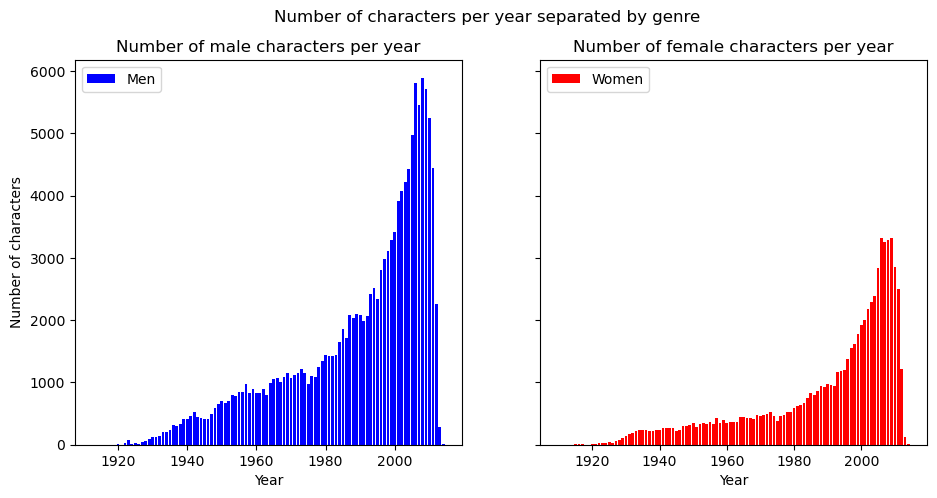

In [23]:
#Look at gender distribution along time
labels_men, counts_men = (np.sort(charadata_filtered[charadata_filtered['actor_gender'] == 'M']['release'].unique())) , charadata_filtered[charadata_filtered['actor_gender'] == 'M'].groupby(['release', 'actor_gender'])['actor_gender'].count()
labels_women, counts_women = (np.sort(charadata_filtered[charadata_filtered['actor_gender'] == 'F']['release'].unique())) , charadata_filtered[charadata_filtered['actor_gender'] == 'F'].groupby(['release', 'actor_gender'])['actor_gender'].count()
fig, (ax0, ax1) = plt.subplots(ncols=2,figsize=(11, 5), sharey = True)

ax0.bar(labels_men, counts_men,label='Men', color = 'blue')
ax1.bar(labels_women, counts_women,label='Women', color = 'red')
ax0.legend(loc='upper left')
ax1.legend(loc='upper left')


ax0.set_title('Number of male characters per year')
ax1.set_title('Number of female characters per year')

ax0.set_ylabel('Number of characters')
ax0.set_xlabel('Year')
ax1.set_xlabel('Year')

fig.suptitle('Number of characters per year separated by genre')

plt.show()

Above, we can observe that there is a constant increase for each category across time from year to year there are no huge drop nor inrease of the number of characters. Thus, we decide to create a column which corresponds to the decade in which the movie was released. Grouping movies by decade still allows a fine temporal resolution with an increased amount of data to perform the analysis on temporal evolution. We devide the dataset by decade as it seems to us that in such a period, the lifestyle remains constant. Indeed, we can asumme that the purchasing power, population, movie habits and genre popularity remained stable in each decade. 

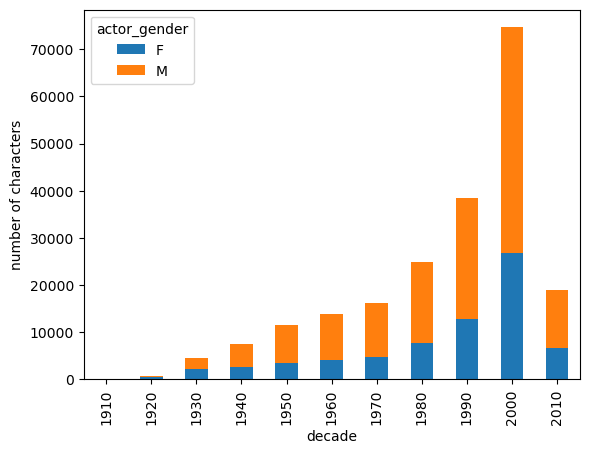

In [24]:
# Add column for decade distinction
charadata_filtered['decade'] = (charadata_filtered['release']//10)*10

# Indicate its decade of release and the year in the decade (ie. 0,1,2,3,4,5,6,7,8,9)
moviedata_filtered['decade'] = (moviedata_filtered['release']//10)*10
moviedata_filtered['year'] = moviedata_filtered['release']%10

#Look at gender distribution along time
charadata_filtered.groupby(['decade', 'actor_gender'])['actor_gender'].count().unstack().plot.bar(stacked=True)
plt.ylabel('number of characters')
plt.show()

We can notice that 1910 and 1920 have only a few movies we can visualize further how many they are per decade. Plus, we know that the data is driven from Wikipedia in 2012 so the 2010 decade is not complete, as we decide to focus on the evolution by decade we may need to remove the last incomplete decade.

In [25]:
count_movies = charadata_filtered.groupby(['decade', 'actor_gender'])['actor_gender'].count()
count_movies

decade  actor_gender
1910    F                  34
        M                  15
1920    F                 425
        M                 359
1930    F                2119
        M                2389
1940    F                2664
        M                4826
1950    F                3542
        M                8036
1960    F                4086
        M                9719
1970    F                4809
        M               11460
1980    F                7623
        M               17154
1990    F               12754
        M               25592
2000    F               26781
        M               47897
2010    F                6689
        M               12244
Name: actor_gender, dtype: int64

We can see that the decade 1910 contains too few values for the gender analysis. We can remove it.

In [26]:
moviedata_filtered = moviedata_filtered.loc[(moviedata_filtered['decade'] > 1910) & (moviedata_filtered['decade'] < 2010)]
charadata_filtered = charadata_filtered.loc[(charadata_filtered['decade'] > 1910) & (charadata_filtered['decade'] < 2010)]
print('We have now {} movies which contain all the necessary data for our analysis.'.format(len(moviedata_filtered)))
print('There are in average {:.2f} characters per movie.'.format(len(charadata_filtered)/len(moviedata_filtered)))

We have now 30663 movies which contain all the necessary data for our analysis.
There are in average 6.27 characters per movie.


After observing the number of men and women per decade to observe distribution, it makes sense to focus on relative distribution, as it is not easily readable in the above plots. Thus, we plotted both the proportion and ratio of men and women in the two visualizations below.

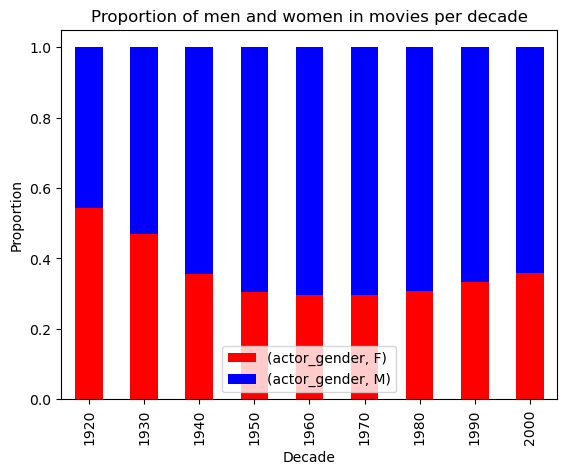

In [35]:
#Plot proportion of genders across time
pd.DataFrame(
    charadata_filtered.groupby(
        ['decade', 'actor_gender'])['actor_gender'].count()/np.repeat(charadata_filtered.groupby(['decade']).size().values, 2)
        ).unstack().plot.bar(stacked=True,title='Proportion of men and women in movies per decade', xlabel='Decade',ylabel='Proportion',color=['red','blue'])
plt.legend()
plt.show()

In [28]:
#Count male and female characters per decade across all movies
gender_count_perdecade = charadata_filtered.groupby('decade').apply(lambda x : pd.Series({'M' : x[x.actor_gender == 'M'].shape[0], 
                                                                                       'F' : x[x.actor_gender == 'F'].shape[0]}))
gender_count_perdecade['F_M_Ratio'] = gender_count_perdecade.F / (gender_count_perdecade.M + gender_count_perdecade.F)

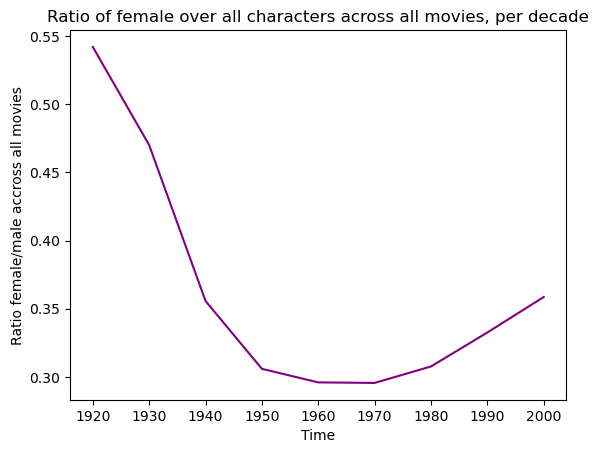

In [29]:
plt.plot(gender_count_perdecade.index, gender_count_perdecade.F_M_Ratio, ls = '-',color='purple')
plt.title("Ratio of female over all characters across all movies, per decade")
plt.xlabel('Time')
plt.ylabel("Ratio female/male accross all movies")
plt.show()

Finally, as we observed the different ratios over time, it is interesting to also decompose the age distribution over decades, and try to see if we can observe an evolution within the general tendency. 

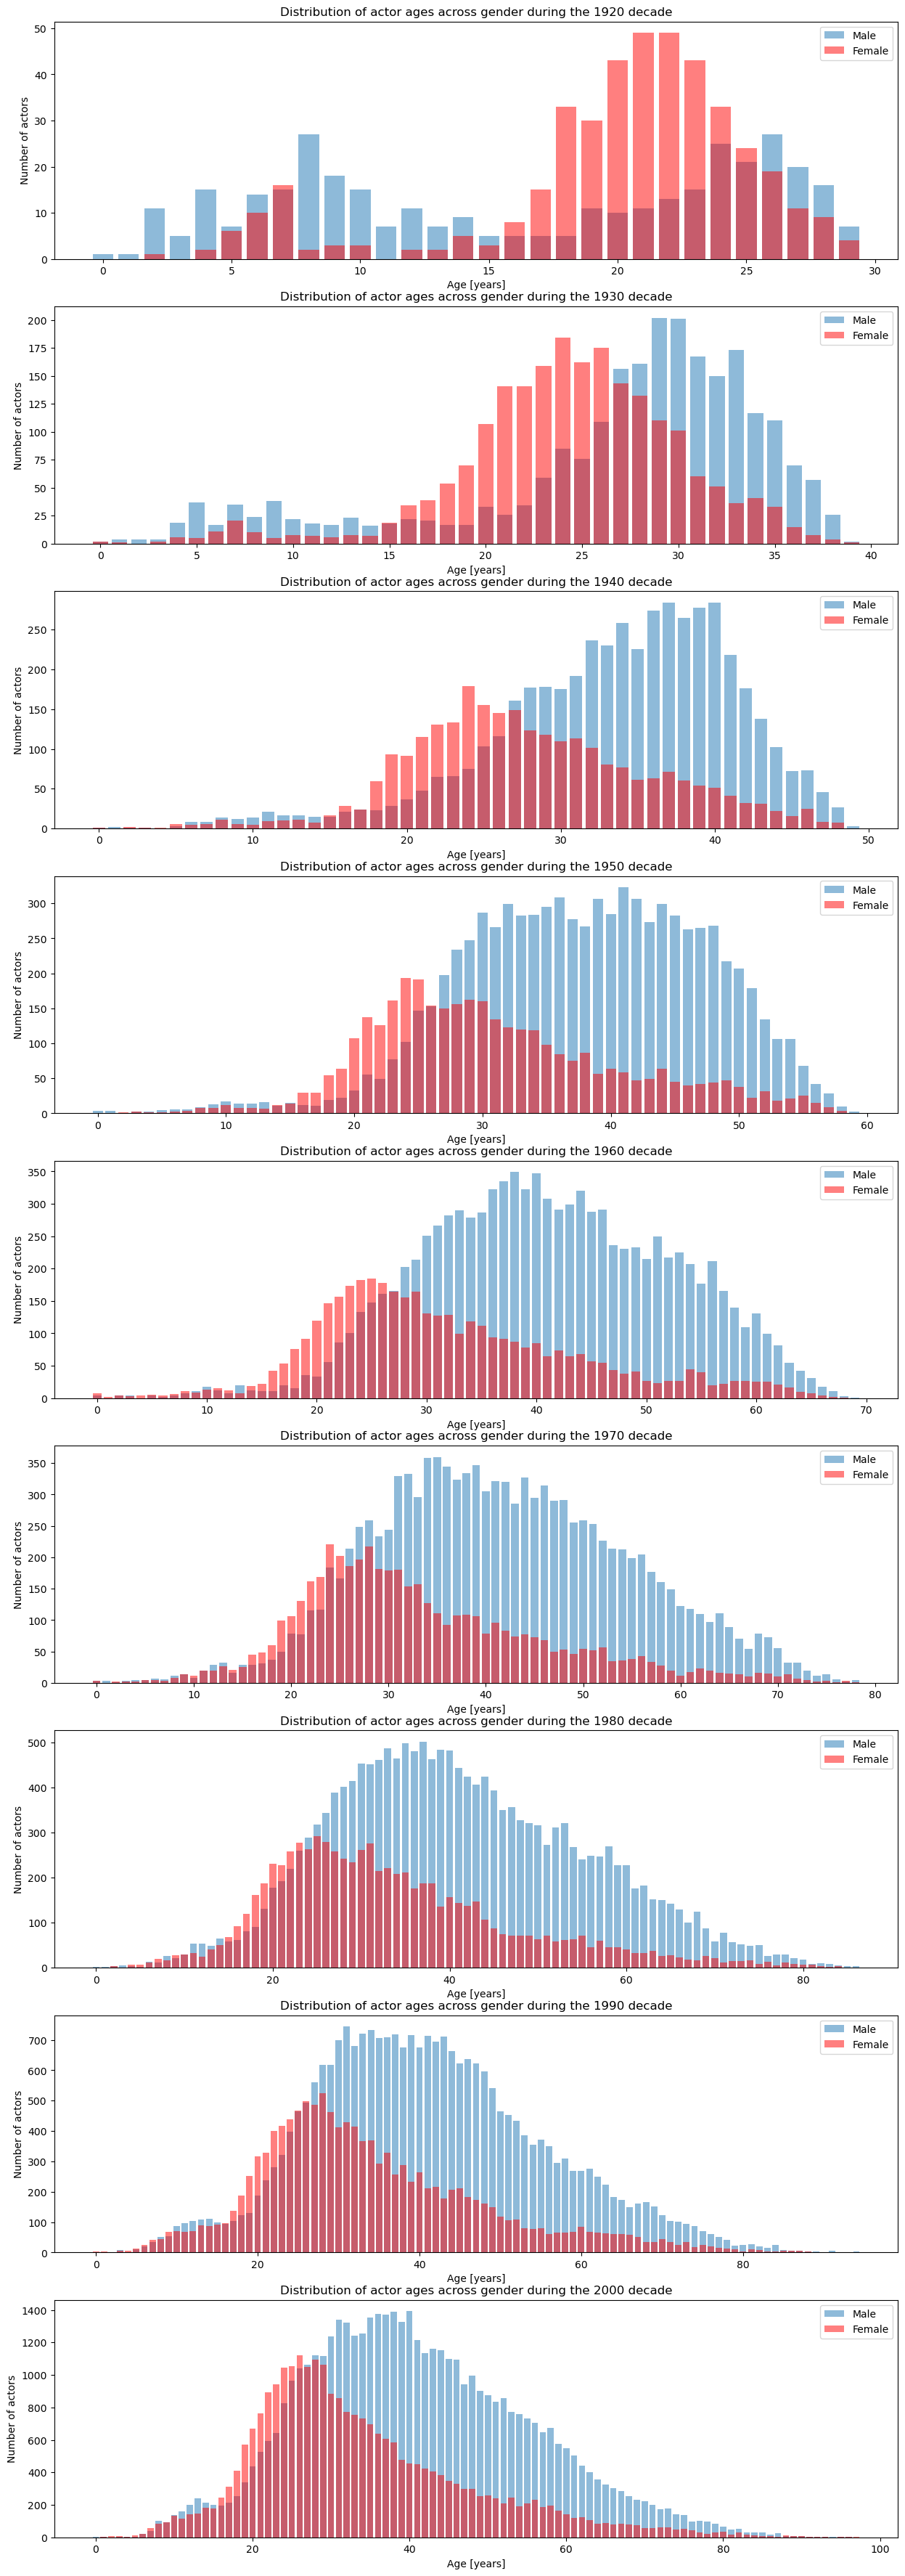

In [31]:
fig,axs=plt.subplots(9,1,figsize=(11, 45))

decades=np.sort(charadata_filtered['decade'].unique())
for i, decade in enumerate(decades) : 
    M=charadata_filtered[(charadata_filtered['actor_gender']=='M') & (charadata_filtered['decade']==decade)]
    F=charadata_filtered[(charadata_filtered['actor_gender']=='F') & (charadata_filtered['decade']==decade)]
    Mc = M['actor_age'].value_counts()
    Fc = F['actor_age'].value_counts()
    
    axs[i].bar(np.sort(Mc.index),Mc[np.sort(Mc.index)],alpha=0.5,label='Male')
    axs[i].bar(np.sort(Fc.index),Fc[np.sort(Fc.index)],alpha=0.5,label='Female',color='red')
    axs[i].set_title(f"Distribution of actor ages across gender during the {decade} decade")
    axs[i].set_xlabel('Age [years]')
    axs[i].set_ylabel('Number of actors')
    axs[i].legend(loc='upper right')

One could think about looking at the women's representation in the film industry depending on geographical location.

In [ ]:
#input : takes a Series composed of lists of variavble sizes 
#output : a 1D Series with the lists placed end to end

def to_1D(series):
    return pd.Series([x for _list in series for x in _list])

In [ ]:
#counts the number of movies sharing the same origin
#Plot the countries which have more than a thousand movies
count_origin = to_1D(moviedata_filtered['countries']).value_counts()
count_origin = count_origin[count_origin>200] 

count_origin.plot(kind='bar')
plt.title('Count of movies per genre')
plt.xlabel('Country of origin')
plt.ylabel('Count')

We can see that a great part of the dataset is composed of american movies, we do not have enough data to take into account the geographical parameter.

#### ANALYSIS BY GENRE

Following the observed trends and results previously obtained, we would like to know wether these apply to distinct genres within the film industry. Analysis accross genres allows to determine the most popular ones which implies a superior impact on the society. Repeating steps previously done such as age and proportion of male vs female characters over time for distinct genres would allow to highligths effects common to the whole industry. Due to the variety of genres in the dataset, it would be better to focus on a lesser extent of genres with a sufficient count for relevance and that are as distinct as possible to study similarity.

Text(0, 0.5, 'Count')

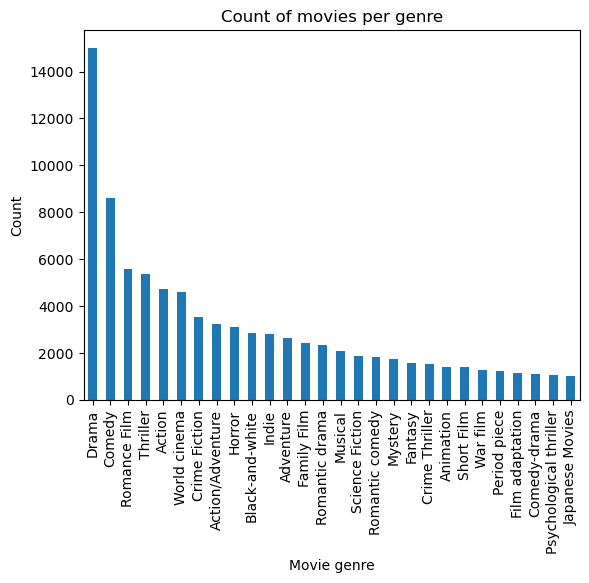

In [ ]:
#counts the number of movies tagged with each genre 
#Plot the genres that contain more than a thousand movies
count_genres = to_1D(moviedata_filtered['genres']).value_counts()
count_genres = count_genres[count_genres>1000] 

count_genres.plot(kind='bar')
plt.title('Count of movies per genre')
plt.xlabel('Movie genre')
plt.ylabel('Count')

We decided to keep the top 10 genres with the highest movie counts to have a sufficient effect size for our following analysis. We notice that the genre World cinema is in the top 10. We decide to remove this genre as it represents all non-american movies while our dataset contains a great part of movies coming from the United States and that it is a movie genre per se.

In [ ]:
selected = count_genres[:10].index #we take the 10 genres with the highest counts of movies
selected = selected.drop(['World cinema']) 
identification_genre = moviedata_filtered[['genres']].copy() # temporary dataframe for genre identification for each movie

In [ ]:
# for each genre checks if the movie is part of a top 10 genre
for i in selected:
    identification_genre[str(i)] = identification_genre['genres'].apply(lambda x: 1 if i in x else 0) # for each genre chekcs if the movie is part of the genre

From these top 10 genres, we want to extract a combination of three genres that provides a sufficient count of movies that are listed in only one of the three genres, that have similar counts, and that have the lowest ratio of removed movies belonging to several genres of the three. This allows the extraction of a combination of three isolated genres. Indeed, this will result in three genres as independent as possible from each other with relative importance in the film industry due to a high movie count. It allows us to compare movies that belong to only one of the three different and independent genres to study if our following analysis shows the same results accross the film industry.

In [ ]:
triplets = list((combinations(selected,3)))   # create all triplets possible for the selected genres
count_per_genre = np.zeros((len(triplets), 3))  # count number of movies for each genre for each triplet 
count_unique_per_genre = np.zeros((len(triplets), 3)) # count number of movies for each genre for each triplet which are not shared by the other genres of the triplet

for i, triplet in enumerate(triplets) :
    for j, genre in enumerate(triplet) :
        count_per_genre[i,j] = identification_genre.loc[:,genre].sum()  
        others = list(triplet)
        others.remove(genre)
        count_unique_per_genre[i,j] = len(identification_genre[(identification_genre[genre] == 1) \
            & (identification_genre[others[0]] != 1)\
            & (identification_genre[others[1]] != 1)])

In [ ]:
#Criteria to select the genre triplet
loss_genres = (count_per_genre - count_unique_per_genre) / count_per_genre  
mean_loss = pd.Series(np.mean(loss_genres, axis=1), index = triplets) # mean per triplet of proportion of loss of number of shared movies    
genre_loss_std = pd.Series(np.std(loss_genres, axis=1), index = triplets) # std of loss of counts of movies in each triplet 
mean_count = pd.Series(np.mean(count_unique_per_genre, axis=1), index = triplets) # mean of counts of movies per triplet

In [ ]:
evaluation_df = pd.concat([mean_loss,genre_loss_std,mean_count],axis=1)
evaluation_df.columns = ['mean count loss', 'std loss', 'mean counts']
fig = px.scatter(evaluation_df , x = 'mean count loss', y = 'std loss', color = 'mean counts', title="Scatter plot evaluating independence for genres in each triplet", width=716, height=750, hover_name = list(mean_count.index))
fig.show()

We can see that the triplet which looses few movie, in which the differences in count in the triplets is minimal and which has an overall high mean of counts of movies in the triplet is Romance Film, Action and Horror. 

In [ ]:
#Check that each movie belongs to only one of the genres present in the triplet
selected_genres = ['Romance Film', 'Action', 'Horror']

for genre in selected_genres:
    moviedata_filtered[genre] = moviedata_filtered['genres'].apply(lambda x: 1 if genre in x else 0)

moviedata_filtered['unique_genre'] = moviedata_filtered.loc[:,selected_genres].sum(axis = 1)

In [ ]:
#Drop movies that belong to more than one genre in the triplet or none of them
unique_genre = moviedata_filtered.drop(moviedata_filtered[moviedata_filtered['unique_genre'] != 1].index)

<AxesSubplot:>

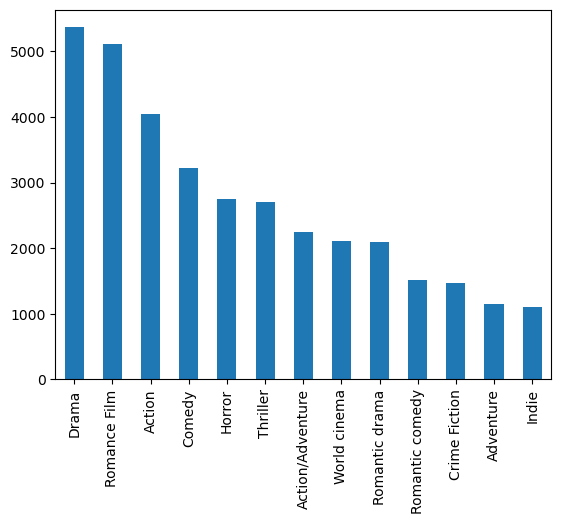

In [ ]:
#Plot the distribution of count of movies that belong to one genre in the triplets
count_selected = to_1D(unique_genre['genres']).value_counts()

count_selected = count_selected[count_selected>1000]

count_selected.plot(kind='bar')

We notice that comedy and Drama have a high count of movies. This means that the movies filtered at this point from the dataset belong in adtion to one of the triplet genre to the Drama or Comedy. This higlights the fact that these genre are more general than others.

In [ ]:
unique_genre.head()

,movie_name,release,countries,genres,decade,year,Romance Film,Action,Horror,unique_genre
wiki_id,,,,,,,,,,
20663735,Narasimham,2000,[India],"[Action, Drama, Musical, Bollywood]",2000,0,0,1,0,1
5272176,End Game,2006,"[Germany, United States of America, Canada]","[Action, Drama, Action/Adventure, Thriller]",2000,6,0,1,0,1
1952976,Dark Water,2005,[United States of America],"[Horror, Drama, Thriller]",2000,5,0,0,1,1
2462689,Meet John Doe,1941,[United States of America],"[Comedy-drama, Romance Film, Americana, Comedy...",1940,1,1,0,0,1
1335380,Exodus,1960,[United States of America],"[Action, Action/Adventure, War film, Epic, Dra...",1960,0,0,1,0,1


In [ ]:
#Select the genre of the triplet to which the movie belongs
for genre in selected_genres:
    unique_genre['genres'] = unique_genre['genres'].apply(lambda x: genre if genre in x else x)

In [ ]:
unique_genre.head()

,movie_name,release,countries,genres,decade,year,Romance Film,Action,Horror,unique_genre
wiki_id,,,,,,,,,,
20663735,Narasimham,2000,[India],Action,2000,0,0,1,0,1
5272176,End Game,2006,"[Germany, United States of America, Canada]",Action,2000,6,0,1,0,1
1952976,Dark Water,2005,[United States of America],Horror,2000,5,0,0,1,1
2462689,Meet John Doe,1941,[United States of America],Romance Film,1940,1,1,0,0,1
1335380,Exodus,1960,[United States of America],Action,1960,0,0,1,0,1


In [ ]:
print('Looking at these three specific genres we can study the evolution of women represention in {} movies'.format(len(unique_genre)))

Looking at these three specific genres we can study the evolution of women represention in 11903 movies


In [ ]:
#Split the previous dataframe in three distinct ones for each genre to allow parallel analysis
horror = unique_genre.loc[unique_genre['genres'] == 'Horror'].copy()
action = unique_genre.loc[unique_genre['genres'] == 'Action'].copy()
romance = unique_genre.loc[unique_genre['genres'] == 'Romance Film'].copy()

In [ ]:
#counts the amount of revenues provided in each genre
horror_count = len(horror.index)
action_count = len(action.index)
romance_count = len(romance.index)
print('We have now {} horror movies extracted.'.format(horror_count))
print('We have now {} horror movies extracted.'.format(action_count))
print('We have now {} horror movies extracted.'.format(romance_count))

We have now 2742 horror movies extracted.
We have now 4051 horror movies extracted.
We have now 5110 horror movies extracted.


Now we will look at the evolution of the number of movies per decade for each of the three genres selected.

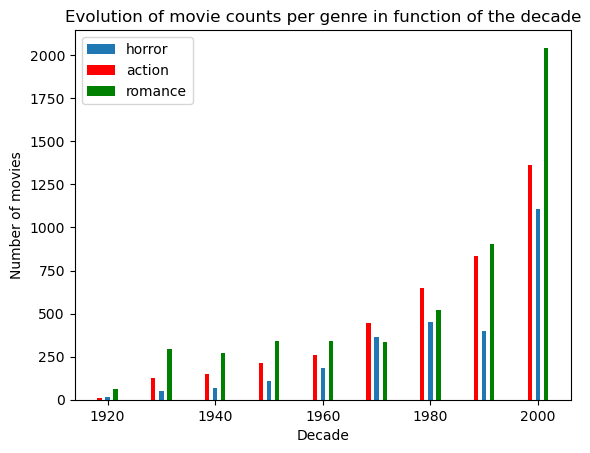

In [ ]:
#Plot the evolution of the movie count per genre and per decade 
plt.bar(horror['decade'].sort_values().unique(), horror.groupby(['decade'])['release'].count(), label = 'horror')
plt.bar(action['decade'].sort_values().unique() - 1.5, action.groupby(['decade'])['release'].count(), color='red', label = 'action')
plt.bar(romance['decade'].sort_values().unique() + 1.5, romance.groupby(['decade'])['release'].count(), color= 'green', label = 'romance')

plt.legend(loc = 'upper left')
plt.title('Evolution of movie counts per genre in function of the decade')
plt.xlabel('Decade')
plt.ylabel('Number of movies')
plt.show()

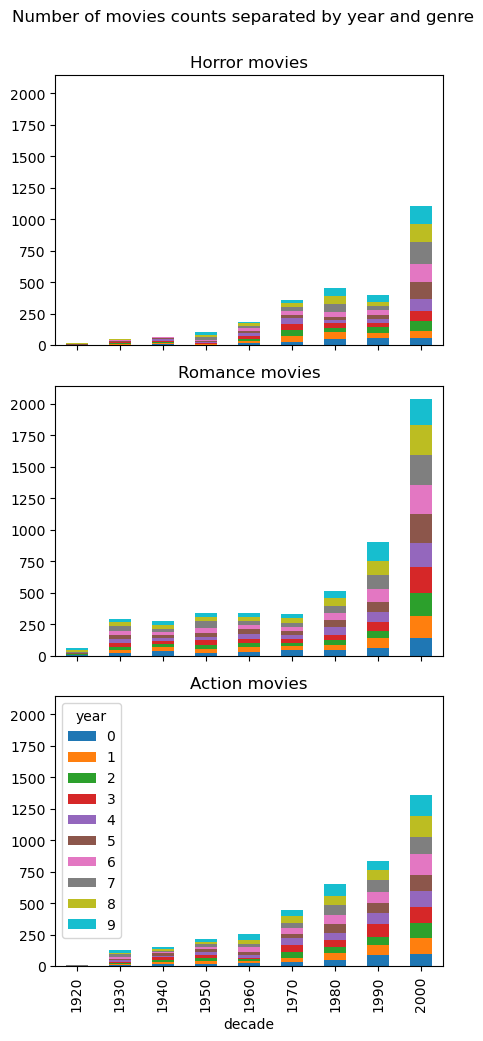

In [ ]:
#Subplot the evolution of the movie per decade for each genre with the detailed count per year
fig = plt.figure(figsize=(5, 11))
gs = fig.add_gridspec(3, hspace=0.15)
axs = gs.subplots(sharex=True, sharey=True)

horror.groupby(['decade', 'year'])['release'].count().unstack().plot.bar(ax = axs[0], stacked=True)
romance.groupby(['decade', 'year'])['release'].count().unstack().plot.bar(ax = axs[1], stacked=True)
action.groupby(['decade', 'year'])['release'].count().unstack().plot.bar(ax = axs[2], stacked=True)

axs[0].get_legend().remove()
axs[1].get_legend().remove()

axs[0].title.set_text('Horror movies')
axs[1].title.set_text('Romance movies')
axs[2].title.set_text('Action movies')

fig.suptitle('Number of movies counts separated by year and genre')
fig.subplots_adjust(top=0.92)

##### Analysis on character's list

In [ ]:
#Select characters according to movies belonging to one of the three genres
horror_charadata = charadata_filtered.loc[horror.index.intersection(charadata_filtered.index)]
action_charadata = charadata_filtered.loc[action.index.intersection(charadata_filtered.index)]
romance_charadata = charadata_filtered.loc[romance.index.intersection(charadata_filtered.index)]
horror_charadata.head()

,release,character_name,actor_gender,actor_name,actor_age,decade
wiki_id,,,,,,
1952976,2005,Mediator,F,Linda Emond,46.0,2000
1952976,2005,Dahlia,F,Jennifer Connelly,34.0,2000
1952976,2005,Mr. Murray,M,John C. Reilly,40.0,2000
1952976,2005,Jeff Platzer,M,Tim Roth,44.0,2000
1952976,2005,Kyle Williams,M,Dougray Scott,39.0,2000


In [ ]:
#Function which analyses character information such as age and gender and compare men and women characteristics
def count_chara(genre_data,character_genre):
    character_genre = character_genre.groupby('wiki_id')
    nb_characters = character_genre['actor_gender'].count()
    genre_data['nb_characters'] = nb_characters
    genre_data['nb_women'] = character_genre['actor_gender'].apply(lambda x: x[x == 'F'].count())
    genre_data['nb_men'] = character_genre['actor_gender'].apply(lambda x: x[x == 'M'].count())
    genre_data['ratio_gender'] = genre_data['nb_women'] / genre_data['nb_men']
    genre_data['average_age_men'] = character_genre.apply(lambda x: x['actor_age'].loc[x['actor_gender'] == 'M'].mean())
    genre_data['average_age_women'] = character_genre.apply(lambda x: x['actor_age'].loc[x['actor_gender'] == 'F'].mean())

In [ ]:
count_chara(horror, horror_charadata)
count_chara(action, action_charadata)
count_chara(romance, romance_charadata)

In [ ]:
# The function computes the means of the age of men and women actors as well as the standard deviations for each decade 

def stats_age_decade(genre_charadata):

    genre_age = genre_charadata.groupby(['decade'])
    mean_age_men = genre_age.apply(lambda x : x.loc[x['actor_gender'] == 'M']['actor_age'].mean())
    std_age_men = genre_age.apply(lambda x : x.loc[x['actor_gender'] == 'M']['actor_age'].std())
    mean_age_women = genre_age.apply(lambda x : x.loc[x['actor_gender'] == 'F']['actor_age'].mean())
    std_age_women = genre_age.apply(lambda x : x.loc[x['actor_gender'] == 'F']['actor_age'].std())

    return mean_age_men, std_age_men, mean_age_women, std_age_women

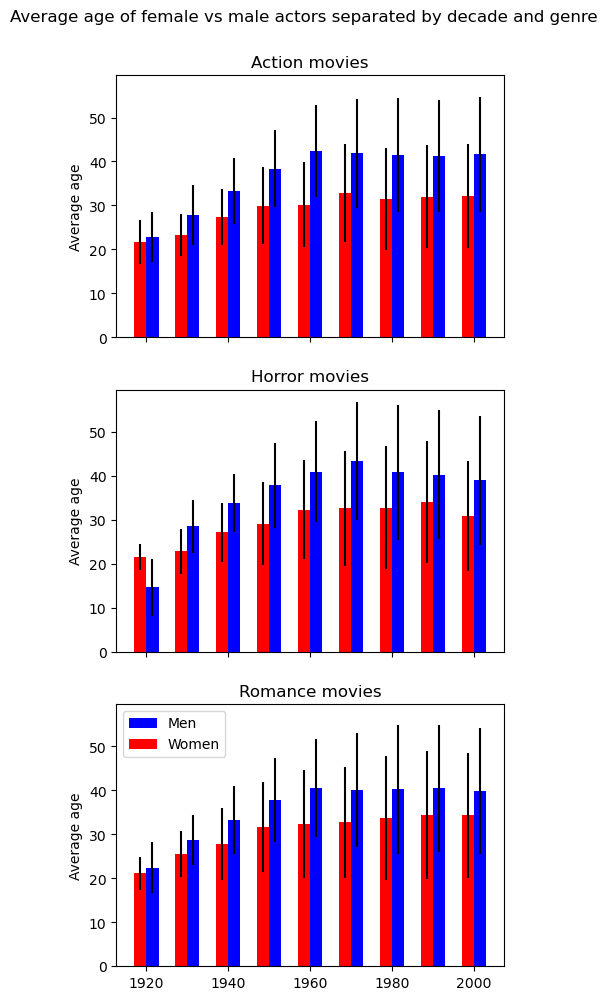

In [ ]:
# Compute some stats for the three selected genres and plot them by decade for each genre
action_age = stats_age_decade(action_charadata)
horror_age = stats_age_decade(horror_charadata)
romance_age = stats_age_decade(romance_charadata)

fig, (ax0, ax1, ax2) = plt.subplots(nrows=3,figsize=(5, 11), sharex = True, sharey = True)
width = 3

ax0.bar(action_age[0].index + width/2, action_age[0],width, yerr = action_age[1],label='Men', color = 'blue')
ax0.bar(action_age[2].index - width/2, action_age[2],width, yerr = action_age[3],  label='Women', color = 'red')
ax1.bar(horror_age[0].index + width/2, horror_age[0],width, yerr = horror_age[1],label='Men', color = 'blue')
ax1.bar(horror_age[2].index - width/2, horror_age[2],width, yerr = horror_age[3],  label='Women', color = 'red')
ax2.bar(romance_age[0].index + width/2, romance_age[0],width, yerr = romance_age[1],label='Men', color = 'blue')
ax2.bar(romance_age[2].index - width/2, romance_age[2],width, yerr = romance_age[3],  label='Women', color = 'red')


ax0.set_title('Action movies')
ax1.set_title('Horror movies')
ax2.set_title('Romance movies')

ax0.set_ylabel('Average age')
ax1.set_ylabel('Average age')
ax2.set_ylabel('Average age')

ax2.legend(loc='upper left')

fig.suptitle('Average age of female vs male actors separated by decade and genre')
fig.subplots_adjust(top=0.92)

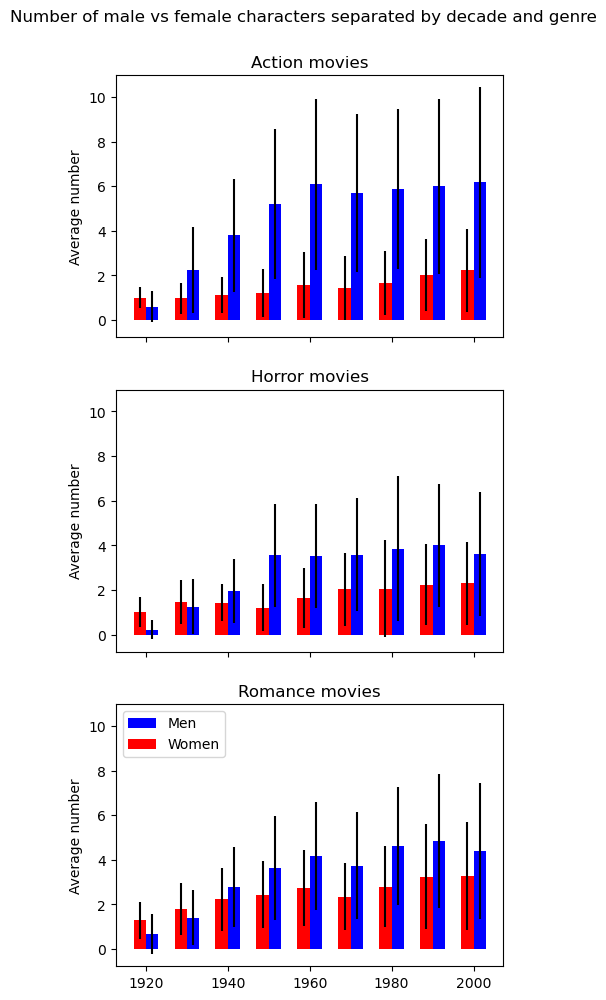

In [ ]:
#Plot the average number of men vs women for each genre over time

width = 3
action_nb_men = action.groupby(['decade'])['nb_men']
action_nb_women = action.groupby(['decade'])['nb_women']
horror_nb_men = horror.groupby(['decade'])['nb_men']
horror_nb_women = horror.groupby(['decade'])['nb_women']
romance_nb_men = romance.groupby(['decade'])['nb_men']
romance_nb_women = romance.groupby(['decade'])['nb_women']

fig, (ax0, ax1, ax2) = plt.subplots(nrows=3,figsize=(5, 11), sharex = True, sharey = True)

ax0.bar(action['decade'].sort_values().unique() + width/2, action_nb_men.mean(),width, yerr = action_nb_men.std(),label='Men', color = 'blue')
ax0.bar(action['decade'].sort_values().unique() - width/2, action_nb_women.mean(),width, yerr = action_nb_women.std(),  label='Women', color = 'red')
ax1.bar(action['decade'].sort_values().unique() + width/2, horror_nb_men.mean(),width, yerr = horror_nb_men.std(),label='Men', color = 'blue')
ax1.bar(action['decade'].sort_values().unique() - width/2, horror_nb_women.mean(),width, yerr = horror_nb_women.std(),  label='Women', color = 'red')
ax2.bar(action['decade'].sort_values().unique() + width/2, romance_nb_men.mean(),width, yerr = romance_nb_men.std(),label='Men', color = 'blue')
ax2.bar(action['decade'].sort_values().unique() - width/2, romance_nb_women.mean(),width, yerr = romance_nb_women.std(),  label='Women', color = 'red')

ax0.set_title('Action movies')
ax1.set_title('Horror movies')
ax2.set_title('Romance movies')

ax0.set_ylabel('Average number')
ax1.set_ylabel('Average number')
ax2.set_ylabel('Average number')

ax2.legend(loc='upper left')

fig.suptitle('Number of male vs female characters separated by decade and genre')
fig.subplots_adjust(top=0.92)

### Language Analysis

In this section, we perform a language extraction using the Supplement: Stanford CoreNLP-processed summaries folder. This contains a series of xml files for each plot summary from the movies aboveabove, run through the Stanford CoreNLP pipeline (tagging, parsing, NER and coref). Following the article `Learning Latent Personas of Film Characters David Bamman, Brendan O'Connor, and Noah A. Smith ACL 2013, Sofia, Bulgaria, August 2013`
We will work on the extraction following cc-processed dependencies from the typed dependency tuples produced by the parser which is collapsed dependencies with propagation of conjunct dependencies. We extract linguistic features such as agent verbs, patient verbs and attributes for each character to evalutae its importance and level of description in the movie. We can therefore evaluate the relevance of female vs male characters for each movie and its evoluation accross deacdes. 

We extract the headwords which are in tuples with the name of each the character and devide them as follow. 

• Agent verbs: Verbs for which the entity is an agent argument (nsubj or agent).

• Patient verbs: Verbs for which the entity is the patient, theme or other argument (dobj, nsubjpass, iobj, or any prepositional argument prep *).

• Attributes: Adjectives and common noun words that relate to the mention as adjectival modifiers, noun-noun compounds, appositives, or copulas (nsubj or appos governors, or nsubj, appos, amod, nn dependents of an entity mention).

In [ ]:
from bs4 import BeautifulSoup #used to parse the xml files 
from bs4 import SoupStrainer #used to get only the a subset of data in the xml file 
import gzip #used to unzip and open the xml files 
import re #used to remove all strange characters in string such as ?! which impair comparinson between string and xml values

NLP_FOLDER = 'CoreNLP/corenlp_plot_summaries/'

First, to extract male and female chracteritics we need the character names to identify the relevant words in the xml files. Therefore we remove all characters without name from our filtered character dataset used in the previous analysis.

In [ ]:
#select only caharacters for which we have both the gender and the charcter name to allow langage analysis
charadata_2 = charadata_filtered[charadata_filtered["character_name"].notna()]
intersection = moviedata_filtered.index.intersection(charadata_2.index)
intersection = plots.index.intersection(intersection)

charadata_2 = charadata_2.reset_index()
movie_2 = moviedata_filtered.loc[intersection, :'year']
movie_2 = movie_2.reset_index()

In order to get representative results in the film industry while reducing time consumption we decided to perform the language anilysis on the same amount of movies per decade for consistency. We thus randomly select 500 movies for each decade in the previous dataset.

In [ ]:
# select 1000 random movies per decade from 1940 to process a langage analysis on the plots
rng = np.random.default_rng(7)

decades = np.arange(1940,2001,10)
sample = []
for decade in decades:
    char_movie = charadata_2[charadata_2['decade'] == decade]
    sample = np.append(sample, rng.choice(char_movie.wiki_id.unique(), size=500, replace = False))


movie_2 = movie_2[movie_2["wiki_id"].isin(sample)]
charadata_2 = charadata_2[charadata_2["wiki_id"].isin(sample)]

charadata_2 = charadata_2.set_index('wiki_id')
movie_2 = movie_2.set_index('wiki_id')

In [ ]:
#Create and initialise colums of the dataframe to count agent verbs, patient verbs and attributes for each character and each movie

movie_2 = movie_2.assign(agent_woman = lambda x : 0)
movie_2 = movie_2.assign(patient_woman = lambda x : 0)
movie_2 = movie_2.assign(attributes_woman = lambda x : 0)
movie_2 = movie_2.assign(agent_man = lambda x : 0)
movie_2 = movie_2.assign(patient_man = lambda x : 0)
movie_2 = movie_2.assign(attributes_man = lambda x : 0)


charadata_2 = charadata_2.assign(agent = lambda x : 0)
charadata_2 = charadata_2.assign(patient = lambda x : 0)
charadata_2 = charadata_2.assign(attributes = lambda x : 0)

In [ ]:
# The function counts the number of time a male or female character has been mentioned in the plot 
# Input: takes list to find character's name occurences from tuple produced by CoreNLP parser, the wiki_id of the movie,
#        dataframes of the movies' data and the characters' data,and string for the role type (i.e. agent, patient, attributes)

def count_chara_NLP(list_name_parser, movie_id, movie_data, character_data, charadata_2, type):

    list_valid_type = ("patient", "agent", "attributes")
    if type not in list_valid_type:
        raise ValueError("Wrong role type, either: patient, agent, attributes")
        
    # For every element extracted from the tuples of the CoreNLP pipeline, add count in the data of the corresponding movie
    for elem in list_name_parser:
        for index, chara in enumerate(character_data['character_name']):
            name_split = chara.split()
            for name_sep in name_split:
                if elem == name_sep: # if name_sep.casefold() in map(str.casefold, list_name_parser):
                    # Count number of words associated to women or men depending of the role type analyzed
                    charadata_2.loc[charadata_2['character_name'] == chara, type] += 1
                    # gender = ''.join(character_data.iloc[index]['actor_gender'].split())
                    if ('M' in character_data.iloc[index]['actor_gender']):
                        movie_data.loc[movie_id, str(type + '_man')] += 1
                    elif ('F' in character_data.iloc[index]['actor_gender']):
                        movie_data.loc[movie_id, str(type + '_woman')] += 1

In [ ]:
# It opens the xml file for each movie in our sample dataset
# Fill the lists of all agent verbs, patient verbs and attributes pressent in the collapsed-ccprocessed-dependencies subpart of the xml file 
# Fill the characteritics columns of all characters for each movie

for movie_id in movie_2.index :
    with gzip.open(NLP_FOLDER + str(movie_id) +'.xml.gz', 'r') as f:
        data = f.read()
    cc_processed = SoupStrainer("collapsed-ccprocessed-dependencies")
    soup = BeautifulSoup(data, "xml", parse_only=cc_processed)
   
    # get the text for one element of the tuples extracted by the parser depending of the list of elements extract
    agent_dependent = [a.find('dependent').get_text() for a in soup.find_all('dep',{'type':'nsubj'})]
    agent_dependent += [a.find('dependent').get_text() for a in soup.find_all('dep',{'type':'agent'})]
    agent_dependent = [re.sub(r"[^a-zA-Z0-9]","",i) for i in agent_dependent] # filter out non alphabetical or numerical characters found


    patient_dependent = [a.find('dependent').get_text() for a in soup.find_all('dep',{'type':'dobj'})]
    patient_dependent += [a.find('dependent').get_text() for a in soup.find_all('dep',{'type':'nsubjpass'})]
    patient_dependent += [a.find('dependent').get_text() for a in soup.find_all('dep',{'type':'iobj'})]
    patient_dependent += [a.find('dependent').get_text() for a in soup.find_all('dep', type = lambda value: value and value.startswith('prep_'))]
    patient_dependent = [re.sub(r"[^a-zA-Z0-9]","",i) for i in patient_dependent]

    attributes_dependent = [a.find('governor').get_text() for a in soup.find_all('dep',{'type':'nsubj'})]
    attributes_dependent += [a.find('governor').get_text() for a in soup.find_all('dep',{'type':'appos'})]
    attributes_dependent += [a.find('dependent').get_text() for a in soup.find_all('dep',{'type':'nsubj'})]
    attributes_dependent += [a.find('dependent').get_text() for a in soup.find_all('dep',{'type':'appos'})]
    attributes_dependent += [a.find('dependent').get_text() for a in soup.find_all('dep',{'type':'amod'})]
    attributes_dependent += [a.find('dependent').get_text() for a in soup.find_all('dep',{'type':'nn'})]
    attributes_dependent = [re.sub(r"[^a-zA-Z0-9]","",i) for i in attributes_dependent]

    movie_chara = charadata_2[charadata_2.index == movie_id][['character_name','actor_gender']].reset_index().copy()
    movie_chara = movie_chara[~movie_chara.isnull().any(axis=1)]

    count_chara_NLP(agent_dependent, movie_id, movie_2, movie_chara, charadata_2, "agent")
    count_chara_NLP(patient_dependent, movie_id, movie_2, movie_chara, charadata_2, "patient")
    count_chara_NLP(attributes_dependent, movie_id, movie_2, movie_chara, charadata_2, "attributes")

In [ ]:
#convert to csv
movie_2.to_csv('movie_langage_data.csv')

Now, we can visualize the repartition and evolution of the proportion of word used to described female characters compared to male over time.

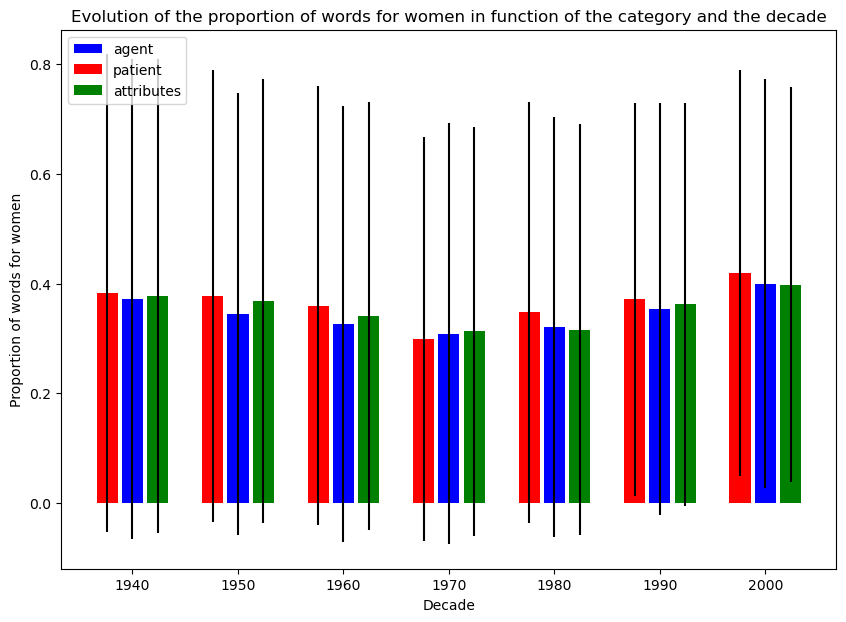

In [ ]:
width = 3

movie_2_grp = movie_2.groupby(['decade'])
agent_mean = movie_2_grp.apply(lambda x : (x['agent_woman']/(x['agent_man'] + x['agent_woman'])).mean())
agent_std = movie_2_grp.apply(lambda x : (x['agent_woman']/(x['agent_man'] + x['agent_woman'])).std())
patient_mean = movie_2_grp.apply(lambda x : (x['patient_woman']/(x['patient_man'] + x['patient_woman'])).mean())
patient_std = movie_2_grp.apply(lambda x : (x['patient_woman']/(x['patient_man'] + x['patient_woman'])).std())
attributes_mean = movie_2_grp.apply(lambda x : (x['attributes_woman']/(x['attributes_man'] + x['attributes_woman'])).mean())
attributes_std = movie_2_grp.apply(lambda x : (x['attributes_woman']/(x['attributes_man'] + x['attributes_woman'])).std())

plt.figure(figsize=(10, 7))

plt.bar(agent_mean.index, agent_mean,width/1.5,label='agent', color = 'blue')
plt.bar(patient_mean.index - width/1.25, patient_mean,width/1.5,  label='patient', color = 'red')
plt.bar(attributes_mean.index + width/1.25, attributes_mean,width/1.5,  label='attributes', color = 'green')


plt.legend(loc = 'upper left')
plt.title('Evolution of the proportion of words for women in function of the category and the decade')
plt.xlabel('Decade')
plt.ylabel('Proportion of words for women')
plt.show()

We can notice a very small increase of the proportion of words for women overtime between 1940s and 2000s. This can result from a higher amount of descriptive words for woman or an higher amount of woman playing in the movies. Another possibility is that the amount of words for male character decreased.

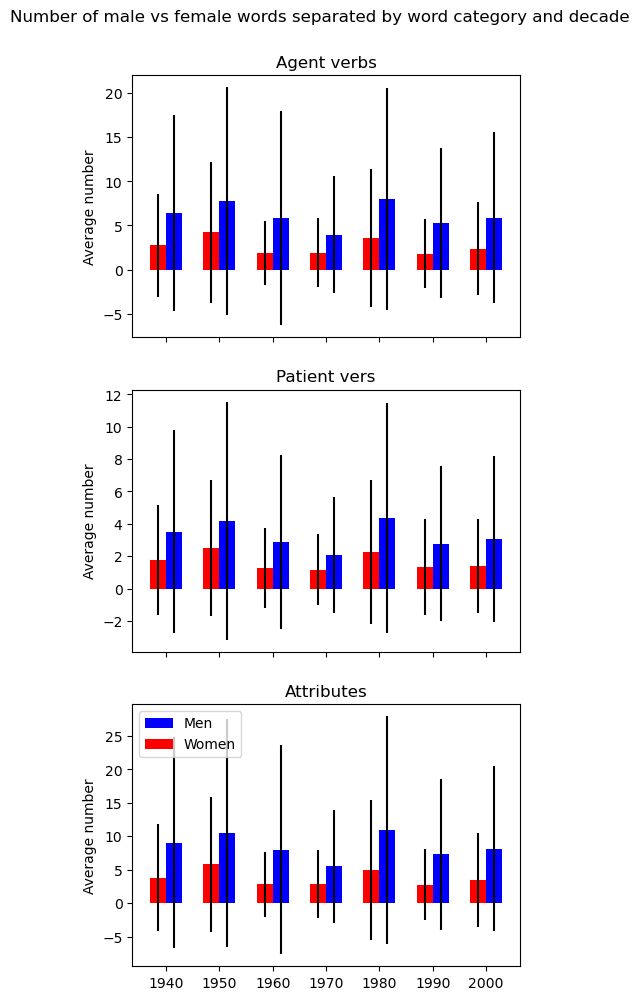

In [ ]:
#Plot the average number of men vs women words for each word category separated by decade
width = 3
movie_2_grp = movie_2.groupby(['decade'])
agent_nb_men = movie_2_grp['agent_man']
agent_nb_women = movie_2_grp['agent_woman']
patient_nb_men = movie_2_grp['patient_man']
patient_nb_women = movie_2_grp['patient_woman']
attributes_nb_men = movie_2_grp['attributes_man']
attributes_nb_women = movie_2_grp['attributes_woman']

fig, (ax0, ax1, ax2) = plt.subplots(nrows=3,figsize=(5, 11), sharex = True, sharey = False)

ax0.bar(movie_2['decade'].unique() + width/2, agent_nb_men.mean(),width, yerr = agent_nb_men.std(),label='Men', color = 'blue')
ax0.bar(movie_2['decade'].unique() - width/2, agent_nb_women.mean(),width, yerr = agent_nb_women.std(),  label='Women', color = 'red')
ax1.bar(movie_2['decade'].unique() + width/2, patient_nb_men.mean(),width, yerr = patient_nb_men.std(),label='Men', color = 'blue')
ax1.bar(movie_2['decade'].unique() - width/2, patient_nb_women.mean(),width, yerr = patient_nb_women.std(),  label='Women', color = 'red')
ax2.bar(movie_2['decade'].unique() + width/2, attributes_nb_men.mean(),width, yerr = attributes_nb_men.std(),label='Men', color = 'blue')
ax2.bar(movie_2['decade'].unique() - width/2, attributes_nb_women.mean(),width, yerr = attributes_nb_women.std(),  label='Women', color = 'red')

ax0.set_title('Agent verbs')
ax1.set_title('Patient vers')
ax2.set_title('Attributes')

ax0.set_ylabel('Average number')
ax1.set_ylabel('Average number')
ax2.set_ylabel('Average number')

ax2.legend(loc='upper left')

fig.suptitle('Number of male vs female words separated by word category and decade')
fig.subplots_adjust(top=0.92)

Here, we cannot assess any constant increase over time in the number of descriptive words for both male and female characters. However, we can assess that male characters are much more developped and described with agent and patient verbs as well as attributes for all decade compared to female characters. 

### Study case: Some geographical insight

We can choose to focus on american (USA) and indian movies and look at the possible differences as both countries of origins have very different cultures.

Text(0.5, 0.98, 'Number of indian vs american movies by decade')

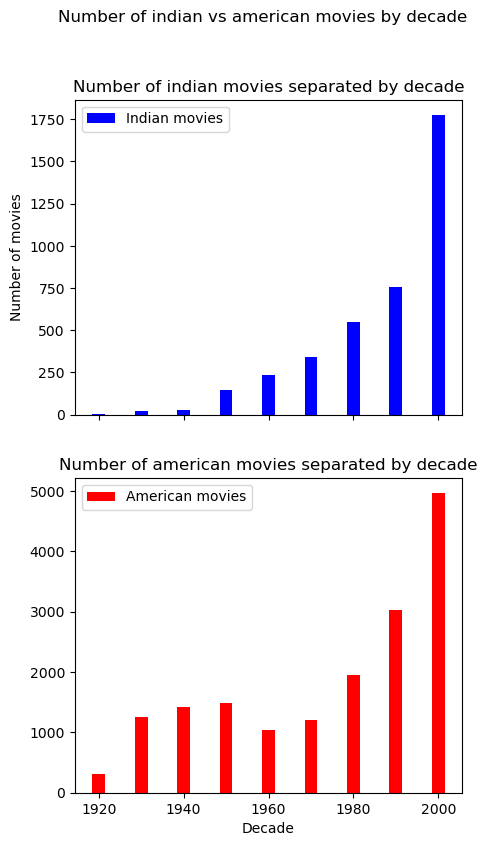

In [ ]:
indian_movies = moviedata_filtered[moviedata_filtered.apply(lambda x : 'India' in x.countries, axis = 1)].copy()
american_movies = moviedata_filtered[moviedata_filtered.apply(lambda x : 'United States of America' in x.countries, axis = 1)].copy()

fig, (ax0, ax1) = plt.subplots(nrows=2,figsize=(5, 9), sharex = True)

ax0.bar(indian_movies['decade'].sort_values().unique(), indian_movies.groupby('decade')['movie_name'].count(), 3,label='Indian movies', color = 'blue')
ax1.bar(american_movies['decade'].sort_values().unique(), american_movies.groupby('decade')['movie_name'].count(), 3,label='American movies', color = 'red')
ax0.legend(loc='upper left')
ax1.legend(loc='upper left')


ax0.set_title('Number of indian movies separated by decade')
ax1.set_title('Number of american movies separated by decade')

ax0.set_ylabel('Number of movies')
ax1.set_xlabel('Decade')

fig.suptitle('Number of indian vs american movies by decade')

From here we can continue our analysis and compare how women are represented in both geographical with the same metrics used before, for example :
- proportion of women
- average age of female actors
- linguistic analysis of the polts 


### Additional dataset: population's reception to women-empowering movies

Metacritic website gathers critiques given by professional movie critics and computes them into a `metascore`. We can use this metascore to assess how movies with important and active main female characters were received by the society at the time the movie aired.

In [ ]:
# Get metascore from already parsed metascore website
url = "https://raw.githubusercontent.com/miazhx/metascore/master/data/metascore_movies.csv"
metascore = pd.read_csv(url)
metascore.head()

In [ ]:
# We keep movies for which we have a metascore
metascore.movie_title = metascore.movie_title.str.lower()
moviedata_filtered.movie_name = moviedata_filtered.movie_name.str.lower()

metascore_filtered = metascore[metascore["movie_title"].isin(moviedata_filtered.movie_name)]
print("We have {} which have a metascore.".format(len(metascore_filtered)))

We have a quite high number of movies with a metascore we can proceed to further analysis 